In [1]:
from ratelearn import (RateMatrix, convert_triplet_to_quantized, estimate_likelihood,
                       generate_data, train_quantization, train_quantization_N)

In [2]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotnine as p9

import torch

# Step 1: Import WAG matrix

In [3]:
data_path = "data/WAG"
smat_path = os.path.join(data_path, "smat.csv")
smat_df = pd.read_csv(smat_path, sep=",", header=None).replace({" ": np.nan}).astype(float).fillna(0.0)
smat = smat_df
# smat += smat.T
smat = np.zeros((20, 20))
smat[1:, :-1] = smat_df.values
smat += smat.T
smat -= np.diag(smat.sum(1))
pd.DataFrame(smat)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-18.944412,0.551571,0.509848,0.738998,1.027040,0.908598,1.582850,1.416720,0.316954,0.193335,0.397915,0.906265,0.893496,0.210494,1.438550,3.370790,2.121110,0.113133,0.240735,2.006010
1,0.551571,-19.136221,0.635346,0.147304,0.528191,3.035500,0.439157,0.584665,2.137150,0.186979,0.497671,5.351420,0.683162,0.102711,0.679489,1.224190,0.554413,1.163920,0.381533,0.251849
2,0.509848,0.635346,-25.958249,5.429420,0.265256,1.543640,0.947198,1.125560,3.956290,0.554236,0.131528,3.012010,0.198221,0.096162,0.195081,3.974230,2.030060,0.071917,1.086000,0.196246
3,0.738998,0.147304,5.429420,-18.166224,0.030295,0.616783,6.174160,0.865584,0.930676,0.039437,0.084805,0.479855,0.103754,0.046730,0.423984,1.071760,0.374866,0.129767,0.325711,0.152335
4,1.027040,0.528191,0.265256,0.030295,-8.236647,0.098818,0.021352,0.306674,0.248972,0.170135,0.384287,0.074034,0.390482,0.398020,0.109404,1.407660,0.512984,0.717070,0.543833,1.002140
5,0.908598,3.035500,1.543640,0.616783,0.098818,-26.385356,5.469470,0.330052,4.294110,0.113917,0.869489,3.894900,1.545260,0.099921,0.933372,1.028870,0.857928,0.215737,0.227710,0.301281
6,1.582850,0.439157,0.947198,6.174160,0.021352,5.469470,-22.185925,0.567717,0.570025,0.127395,0.154263,2.584430,0.315124,0.081134,0.682355,0.704939,0.822765,0.156557,0.196303,0.588731
7,1.416720,0.584665,1.125560,0.865584,0.306674,0.330052,0.567717,-8.574782,0.249410,0.030450,0.061304,0.373558,0.174100,0.049931,0.243570,1.341820,0.225833,0.336983,0.103604,0.187247
8,0.316954,2.137150,3.956290,0.930676,0.248972,4.294110,0.570025,0.249410,-21.479224,0.138190,0.499462,0.890432,0.404141,0.679371,0.696198,0.740169,0.473307,0.262569,3.873440,0.118358
9,0.193335,0.186979,0.554236,0.039437,0.170135,0.113917,0.127395,0.030450,0.138190,-20.697288,3.170970,0.323832,4.257460,1.059470,0.099929,0.319440,1.458160,0.212483,0.420170,7.821300


In [4]:
pmat_path = os.path.join(data_path, "p_diag.txt")
p_mat = pd.read_csv(pmat_path, header=None, sep=" ").astype(float).iloc[0].values
assert p_mat.shape[0] == 20
assert p_mat.sum() >= .99
assert p_mat.sum() <= 1.01
p_mat = p_mat / p_mat.sum()
p = np.diag(p_mat)

In [5]:
p_mat.shape[0]

20

## Parameter initialization

In [6]:
Q_true = torch.tensor(smat @ p).float().cuda()
num_states = 20
pi = torch.tensor(p_mat).float()

# Preliminary analysis

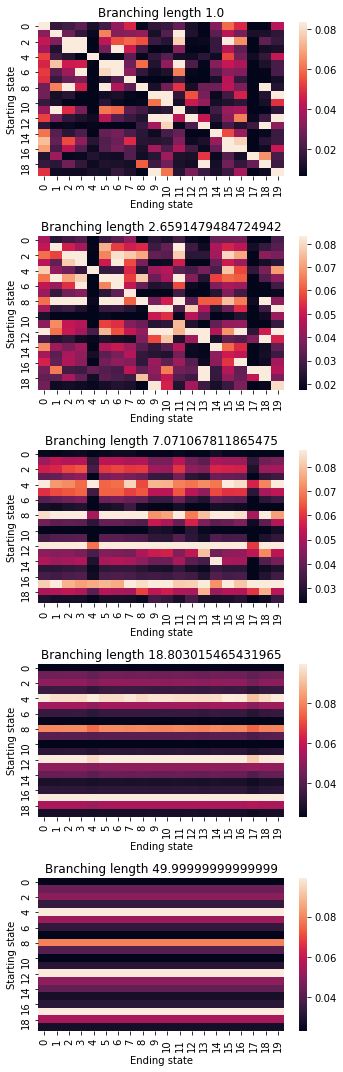

In [7]:
fig, axes = plt.subplots(nrows=5, figsize=(5, 15))
# for idx, time in enumerate(np.geomspace(1e-3, 10, 5)):
for idx, time in enumerate(np.geomspace(1e0, 50, 5)):
    plt.sca(axes[idx])
    transitions = torch.matrix_exp(time * Q_true)
    matri = transitions.cpu().numpy()
    vmin = np.percentile(matri, 10.)
    vmax = np.percentile(matri, 90.)
    sns.heatmap(transitions.cpu().numpy(), vmin=vmin, vmax=vmax)
    plt.ylabel("Starting state")
    plt.xlabel("Ending state")
    plt.title("Branching length {}".format(time))
#     plt.show()
plt.tight_layout()

# Model fitting

In [20]:
tdata = generate_data(Q_true=Q_true, m=int(1e6), batch_size=1000, quantile=20.)

quantized_data = convert_triplet_to_quantized(tdata=tdata, num_states=num_states, q=100)

mat_module = RateMatrix(num_states=num_states, mode="stationary", pi=pi).cuda()
df_res, Q = train_quantization(
    rate_module=mat_module, 
    quantized_dataset=quantized_data,
    lr=1e-4,
    num_epochs=2000,
    Q_true=Q_true,
)

In [71]:
len(quantized_data)

100

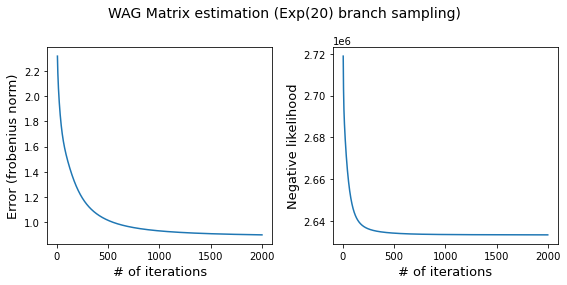

In [46]:
FT_SIZE = 13
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))
plt.sca(axes[1])
df_res.loss.iloc[5:].plot()
plt.ylabel("Negative likelihood", fontsize=FT_SIZE)
plt.xlabel("# of iterations", fontsize=FT_SIZE)
plt.sca(axes[0])
df_res.frob_norm.iloc[5:].plot()
plt.ylabel("Error (frobenius norm)", fontsize=FT_SIZE)
plt.xlabel("# of iterations", fontsize=FT_SIZE)

plt.suptitle("WAG Matrix estimation (Exp(20) branch sampling)", fontsize=FT_SIZE+1)
plt.tight_layout()
# plt.savefig("figures/wag_20.pdf")

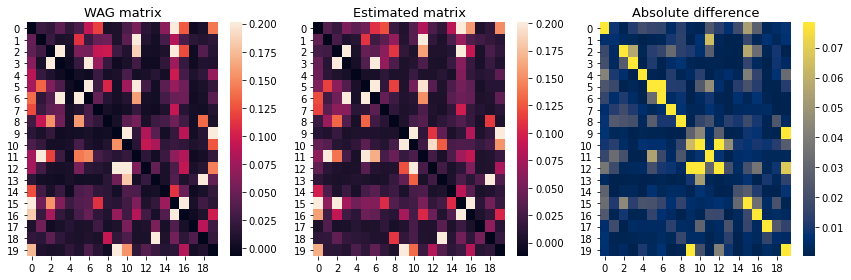

In [61]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

plt.sca(axes[1])
matri = (Q.detach().cpu().numpy())
vmin = np.percentile(matri, 5)
vmax = np.percentile(matri, 95)
sns.heatmap(matri, vmin=vmin, vmax=vmax)
axes[1].set_title('Estimated matrix', fontsize=FT_SIZE)

plt.sca(axes[0])
matri = (Q_true.detach().cpu().numpy())
vmin = np.percentile(matri, 5)
vmax = np.percentile(matri, 95)
sns.heatmap(matri, vmin=vmin, vmax=vmax)
axes[0].set_title('WAG matrix', fontsize=FT_SIZE)

plt.sca(axes[2])
matri = (Q.detach().cpu().numpy()) - (Q_true.detach().cpu().numpy())
matri = np.abs(matri)
vmin = np.percentile(matri, 5)
vmax = np.percentile(matri, 95)
sns.heatmap(matri, vmin=vmin, vmax=vmax, cmap="cividis")
axes[2].set_title('Absolute difference', fontsize=FT_SIZE)
plt.tight_layout()
# plt.savefig("figures/matrices_20.pdf")

### Idea: weight init

In [28]:
m = int(1e6)
tdata = generate_data(Q_true=Q_true, m=m, batch_size=1000, quantile=100., alpha=0.5)
quantized_data = convert_triplet_to_quantized(tdata=tdata, num_states=num_states, q=200)

Generating 1000000 synthetic datapoints of the form (starting_state, ending_state, branch_length)
rate 0.006931471805599453


/data/yosef2/users/pierreboyeau/phylo/ratelearn/ratelearn/simulate.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([200]) torch.Size([200, 20, 20])


In [29]:
lkl_estimates = pd.DataFrame()
for i in range(100):
    torch.manual_seed(i)
    mat_module = RateMatrix(num_states=num_states, mode="stationary", pi=pi).cuda()
    lkl = estimate_likelihood(mat_module, quantized_data, m=m)
    lkl_estimates = lkl_estimates.append(dict(neg_lkl=lkl, seed=i), ignore_index=True)
best_seed = lkl_estimates.set_index("seed").squeeze().argmin()

In [30]:
torch.manual_seed(best_seed)
mat_module = RateMatrix(num_states=num_states, mode="stationary", pi=pi).cuda()

In [52]:
torch.manual_seed(590345)
mat_module = RateMatrix(num_states=num_states, mode="stationary", pi=pi).cuda()
df_res, Q = train_quantization(
    rate_module=mat_module, 
    quantized_dataset=quantized_data,
    lr=5e2,
    num_epochs=3000,
    Q_true=Q_true,
    m=m,
)

Training for 3000 epochs


  0%|          | 0/3000 [00:00<?, ?it/s]

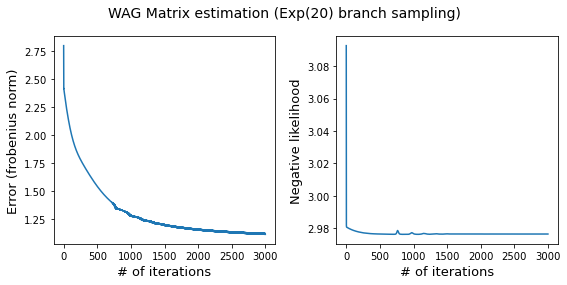

In [53]:
FT_SIZE = 13
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))
plt.sca(axes[1])
# df_res.loss.iloc[5:].plot()
df_res.loss.plot()

plt.ylabel("Negative likelihood", fontsize=FT_SIZE)
plt.xlabel("# of iterations", fontsize=FT_SIZE)
plt.sca(axes[0])
# df_res.frob_norm.iloc[5:].plot()
df_res.frob_norm.plot()

plt.ylabel("Error (frobenius norm)", fontsize=FT_SIZE)
plt.xlabel("# of iterations", fontsize=FT_SIZE)

plt.suptitle("WAG Matrix estimation (Exp(20) branch sampling)", fontsize=FT_SIZE+1)
plt.tight_layout()
# plt.savefig("figures/wag_20.pdf")

# Experimental analysis

## Effect of branch sampling type

## Effect of branch sampling range

In [62]:
df_res

,epoch,frob_norm,loss,time
0,0.0,2.681576,2.796083e+06,0.086731
1,1.0,2.576543,2.770858e+06,0.132007
2,2.0,2.491289,2.752227e+06,0.176888
3,3.0,2.421549,2.738112e+06,0.229256
4,4.0,2.363990,2.727283e+06,0.277627
...,...,...,...,...
1995,1995.0,0.901325,2.633351e+06,100.420117
1996,1996.0,0.901312,2.633351e+06,100.470282
1997,1997.0,0.901299,2.633351e+06,100.518696
1998,1998.0,0.901287,2.633351e+06,100.570354


In [65]:
df_res_all = pd.DataFrame()
for qt in [0.1, 1, 5, 10, 25, 50, 100, 200]:
    tdata = generate_data(Q_true=Q_true, m=int(1e6), batch_size=1000, quantile=qt)
    quantized_data = convert_triplet_to_quantized(tdata=tdata, num_states=num_states, q=100)
    mat_module = RateMatrix(num_states=num_states, mode="stationary", pi=pi).cuda()
    df_res, Q = train_quantization(
        rate_module=mat_module, 
        quantized_dataset=quantized_data,
        lr=1e-4,
        num_epochs=2000,
        Q_true=Q_true,
    )
    df_res = df_res.assign(quantile_value=qt)
    df_res_all = df_res_all.append(df_res)

Generating 1000000 synthetic datapoints of the form (starting_state, ending_state, branch_length)


/data/yosef2/users/pierreboyeau/phylo/ratelearn/ratelearn/simulate.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q_true = torch.tensor(Q_true, device="cuda")


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([100]) torch.Size([100, 20, 20])
Training for 2000 epochs


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating 1000000 synthetic datapoints of the form (starting_state, ending_state, branch_length)


/data/yosef2/users/pierreboyeau/phylo/ratelearn/ratelearn/simulate.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q_true = torch.tensor(Q_true, device="cuda")


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([100]) torch.Size([100, 20, 20])
Training for 2000 epochs


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating 1000000 synthetic datapoints of the form (starting_state, ending_state, branch_length)


/data/yosef2/users/pierreboyeau/phylo/ratelearn/ratelearn/simulate.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q_true = torch.tensor(Q_true, device="cuda")


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([100]) torch.Size([100, 20, 20])
Training for 2000 epochs


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating 1000000 synthetic datapoints of the form (starting_state, ending_state, branch_length)


/data/yosef2/users/pierreboyeau/phylo/ratelearn/ratelearn/simulate.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q_true = torch.tensor(Q_true, device="cuda")


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([100]) torch.Size([100, 20, 20])
Training for 2000 epochs


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating 1000000 synthetic datapoints of the form (starting_state, ending_state, branch_length)


/data/yosef2/users/pierreboyeau/phylo/ratelearn/ratelearn/simulate.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q_true = torch.tensor(Q_true, device="cuda")


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([100]) torch.Size([100, 20, 20])
Training for 2000 epochs


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating 1000000 synthetic datapoints of the form (starting_state, ending_state, branch_length)


/data/yosef2/users/pierreboyeau/phylo/ratelearn/ratelearn/simulate.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q_true = torch.tensor(Q_true, device="cuda")


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([100]) torch.Size([100, 20, 20])
Training for 2000 epochs


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating 1000000 synthetic datapoints of the form (starting_state, ending_state, branch_length)


/data/yosef2/users/pierreboyeau/phylo/ratelearn/ratelearn/simulate.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q_true = torch.tensor(Q_true, device="cuda")


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([100]) torch.Size([100, 20, 20])
Training for 2000 epochs


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating 1000000 synthetic datapoints of the form (starting_state, ending_state, branch_length)


/data/yosef2/users/pierreboyeau/phylo/ratelearn/ratelearn/simulate.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q_true = torch.tensor(Q_true, device="cuda")


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

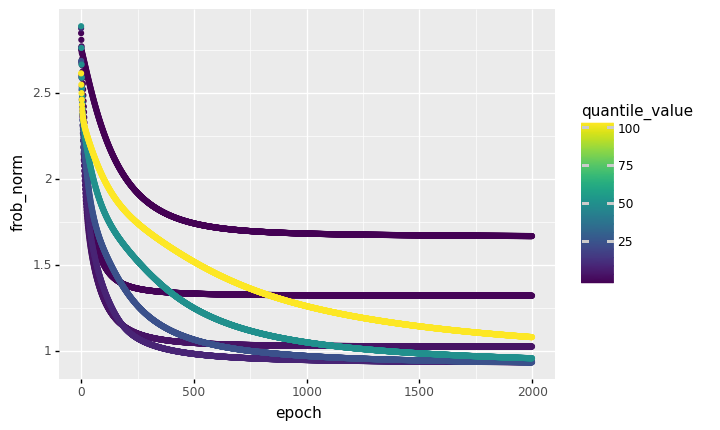

<ggplot: (8749911249277)>

In [69]:
(
    p9.ggplot(df_res_all, p9.aes(x="epoch", y="frob_norm", color="quantile_value"))
    + p9.geom_point()
)